## Chain

### 1. Set Environment Variables

In [1]:
from utils.util import auto_log_and_state
from utils.util import set_env
set_env()

### 2. Test for Simple Message and Model

2.1 Messages

In [2]:
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

2.2 Model

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

In [4]:
import sys
for chunk in llm.stream(messages):
    print(f"\033[1;32m{chunk.content}\033[0m",end="")
    sys.stdout.flush()

The best place to see orcas in the United States is the Pacific Northwest, particularly around the San Juan Islands in Washington State. This area is renowned for its resident orca pods, which are often seen during the summer months. Here are a few key locations and details:

1. **San Juan Islands, Washington**: 
   - The San Juan Islands are one of the most popular spots for orca watching. The resident Southern Resident orcas are often seen here, especially between May and October.
   - You can take boat tours from Friday Harbor on San Juan Island or from other nearby islands.

2. **Puget Sound, Washington**: 
   - Orcas can also be seen in Puget Sound, particularly in the spring and fall when they are following the salmon runs.
   - Tours often depart from cities like Seattle and Tacoma.

3. **Strait of Juan de Fuca, Washington**:
   - This area, located between the Olympic Peninsula and Vancouver Island, is another prime location for orca sightings.

When planning a trip, it’s impor

### 3. Build Graph and Router

3.1 Set Libraries

In [5]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

3.2 Set LLM with Tools

In [6]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    print("Passing Through Tool Function ..")
    print(f"a: {a}, b: {b}")
    return a * b

llm_with_tools = llm.bind_tools([multiply])

3.3 Build Graph

- `tools_condition` is a function that returns `True` if the latest message (result) from the assistant is a tool call; otherwise, it returns `False`.  
  - If the latest message from the assistant = `tool call`, `tools_condition` routes to `tools`.  
  - If the latest message from the assistant = `not tool call`, `tools_condition` routes to `END`.

- `Node__tool_calling_llm`  
  - Select a tool and specify parameters.
  - return type : AIMessage

- `ToolNode`  
  - actual computation is performed based on the selected tool and its parameters.
  - return type : ToolMessage

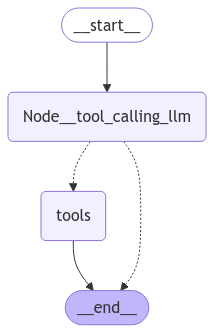

In [7]:
# Node
@auto_log_and_state
def Node__tool_calling_llm(state:MessagesState):
    print("Passing Through Node ..")
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)

# set Node
builder.add_node("Node__tool_calling_llm", Node__tool_calling_llm)
builder.add_node("tools", ToolNode([multiply])) # Set Tools to Node

# set Edge
builder.add_edge(START, "Node__tool_calling_llm")
builder.add_conditional_edges("Node__tool_calling_llm",tools_condition)
builder.add_edge("tools", END) # Must set name of Node to tools

# compile graph
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

if don't call tool
- AIMessage have content.
- AIMessage don't have additional_kwargs={'tool_calls'}

In [8]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
messages


## Passing Through [Node__tool_calling_llm] ..

#### Input State ..
[HUMAN] : Hello!
Passing Through Node ..

#### Output State ..
[AI] : Hello! How can I assist you today?


{'messages': [HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='bb2c3e3a-1511-42e6-a88d-f076a852c2b4'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 54, 'total_tokens': 65, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549', 'finish_reason': 'stop', 'logprobs': None}, id='run-b435165d-fb97-4614-9a40-c582ee98273e-0', usage_metadata={'input_tokens': 54, 'output_tokens': 11, 'total_tokens': 65, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

if call tool
- AIMessage don't have content.
- AIMessage have additional_kwargs={'tool_calls'}

In [28]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
messages

Passing Through Node ..
Passing Through Tool Function ..
a: 2, b: 3


{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='f0fd76b0-7f5e-4005-b15c-fa96ae43441e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bptJ9MiFewmng9j9SBwhJEWw', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 58, 'total_tokens': 76, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c556bc67-576b-4cb8-bc04-05ee2e4a9fa9-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_bptJ9MiFewmng9j9SBwhJEWw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 58, 'output_tokens': 1